In [2]:
import os 
import wget
import array
import gzip
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from collections import defaultdict
from scipy.spatial import distance
from sklearn.manifold import TSNE

Data is available at http://cseweb.ucsd.edu/~jmcauley/pml/data/. 
- Download and save to your own directory.
- Or, run following script to save it into `Chapter_9/data` folder automatically.

In [3]:
filenames = [
    'image_features_Baby.b',
    'meta_Baby.json.gz',
    'meta_Musical_Instruments.json.gz',
    'image_features_Musical_Instruments.b',
    'meta_Musical_Instruments.json.gz',
]

dataDir = './data'
url = 'http://jmcauley.ucsd.edu/pml_data'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)
for filename in filenames:
    wget.download(os.path.join(url, filename), out=dataDir)

print("Done!")

Done!


# Visual compatibility model

This code reads image data in a specific binary format, described here: http://jmcauley.ucsd.edu/data/amazon/links.html

In [4]:
def readImageFeatures(path):
    f = open(path, 'rb')
    while True:
        asin = f.read(10).decode('utf-8') 
        if len(asin) < 10: break
        a = array.array('f')
        a.fromfile(f, 4096)
        yield str(asin), a.tolist()

In [5]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [10]:
X = []
asinPos = {}

for asin, f in readImageFeatures(os.path.join(dataDir, 'image_features_Baby.b')):
    asinPos[asin] = len(X)
    X.append(tf.constant(f, shape=[1,len(f)]))

2022-03-19 09:14:21.122109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 09:14:21.128868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 09:14:21.129176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 09:14:21.129705: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Extract metadata describing ground-truth compatibility relationships among items

In [ ]:
compat = []
asinList = list(asinPos.keys())
for l in parse(os.path.join(dataDir, 'meta_Baby.json.gz')):
    a1 = l['asin']
    if 'related' in l and 'also_bought' in l['related']:
        for a2 in l['related']['also_bought']:
            if a1 in asinPos and a2 in asinPos:
                compat.append((asinPos[a1],asinPos[a2],1))
                compat.append((random.randint(0, len(X)-1),random.randint(0, len(X)-1), 0))

Number of compatible pairs

In [ ]:
len(compat)

1698622

In [ ]:
featDim = X[0].shape[1] # Image feature dimensionality
styleDim = 5 # Dimensionality of compressed (projected) representations

In [ ]:
featDim

4096

Define the compatibility model

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.00001)

In [ ]:
class CompatibilityModel(tf.keras.Model):
    def __init__(self, featDim, styleDim):
        super(CompatibilityModel, self).__init__()
        self.E1 = tf.Variable(tf.random.normal([featDim,styleDim],stddev=0.001))
        self.E2 = tf.Variable(tf.random.normal([featDim,styleDim],stddev=0.001))
        self.c = tf.Variable(0.0)
        
    def predict(self, x1, x2):
        s1 = tf.matmul(x1, self.E1)
        s2 = tf.matmul(x2, self.E2)
        return tf.math.sigmoid(self.c - tf.reduce_sum(tf.math.squared_difference(s1,s2)))

    def call(self, x1, x2, y):
        return -tf.math.log(self.predict(x1,x2)*(2*y - 1) - y + 1)

model = CompatibilityModel(featDim, styleDim)

In [ ]:
def trainingStep(compat):
    with tf.GradientTape() as tape:
        (i1,i2,y) = random.choice(compat)
        x1,x2 = X[i1],X[i2]
        objective = model(x1,x2,y)
    gradients = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return objective.numpy()

In [ ]:
for i in range(50000):
    obj = trainingStep(compat)
    if (i % 5000 == 4999): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 5000, objective = 0.51231325
iteration 10000, objective = 0.6379045
iteration 15000, objective = 0.7741432
iteration 20000, objective = 0.7855767
iteration 25000, objective = 0.46546566
iteration 30000, objective = 0.4155722
iteration 35000, objective = 0.7017366
iteration 40000, objective = 0.83796984
iteration 45000, objective = 0.66832584
iteration 50000, objective = 0.41149664


# Exercises

### 9.1

For these exercises we use musical instrument data; we do so because (a) it has fine-grained subcategories (e.g. "accessories", "guitars", etc.) which can be used for these exercises; and (b) because it is small. These exercises might ideally be run with a large category of (e.g.) clothing images, though such datasets are larger and more difficult to work with.

First collect the subcategories associated with each item (for use in Exercise 9.3)

In [ ]:
categories = dict()
itemsPerCategory = defaultdict(set)
for l in parse(os.path.join(dataDir, 'meta_Musical_Instruments.json.gz')):
    cats = l['categories'][0]
    if len(cats) < 2:
        continue
    cat = cats[1] # Extract the "second level" (or sub-) category, for products that have them (ignore others)
    categories[l['asin']] = cat
    itemsPerCategory[cat].add(l['asin'])

Read image data

In [ ]:
X = []
asinPos = {}
posPerCategory = defaultdict(set)

for asin, f in readImageFeatures(os.path.join(dataDir, 'image_features_Musical_Instruments.b')):
    if not asin in categories: # Skip items for which we don't have a category
        continue
    asinPos[asin] = len(X)
    posPerCategory[categories[asin]].add(asinPos[asin])
    X.append(tf.constant(f, shape=[1,len(f)]))

Extract compatibility relationships. Build our collection of "difficult" negatives consisting of items from the same category.

In [ ]:
compat = []
asinList = list(asinPos.keys())
for l in parse(os.path.join(dataDir, 'meta_Musical_Instruments.json.gz')):
    a1 = l['asin']
    if not a1 in categories:
        continue
    cat = categories[a1]
    if 'related' in l and 'also_bought' in l['related']:
        for a2 in l['related']['also_bought']:
            if not a2 in categories or categories[a2] != cat:
                continue # Only consider positive relations of the same category
            if a1 in asinPos and a2 in asinPos:
                compat.append((asinPos[a1],asinPos[a2],1))
                negSameCat = random.sample(posPerCategory[cat],1)[0]
                compat.append((asinPos[a1],negSameCat, 0))

In [7]:
len(compat)

NameError: name 'compat' is not defined

In [8]:
featDim = X[0].shape[1] # Image feature dimensionality
styleDim = 5 # Dimensionality of compressed (projected) representations

IndexError: list index out of range

In [9]:
optimizer = tf.keras.optimizers.Adam(0.00001)

In [20]:
class CompatibilityModel(tf.keras.Model):
    def __init__(self, featDim, styleDim):
        super(CompatibilityModel, self).__init__()
        self.E1 = tf.Variable(tf.random.normal([featDim,styleDim],stddev=0.001))
        self.E2 = tf.Variable(tf.random.normal([featDim,styleDim],stddev=0.001))
        self.c = tf.Variable(0.0)
        
    def predict(self, x1, x2):
        s1 = tf.matmul(x1, self.E1)
        s2 = tf.matmul(x2, self.E2)
        return tf.math.sigmoid(self.c - tf.reduce_sum(tf.math.squared_difference(s1,s2)))

    def call(self, x1, x2, y):
        return -tf.math.log(self.predict(x1, x2)*(2*y - 1) - y + 1)

### 9.2 / 9.3

Modify the model to compute similarity based on the inner product rather than Euclidean distance

In [21]:
class CompatibilityModelInner(tf.keras.Model):
    def __init__(self, featDim, styleDim):
        super(CompatibilityModel, self).__init__()
        self.E1 = tf.Variable(tf.random.normal([featDim,styleDim],stddev=0.001))
        self.E2 = tf.Variable(tf.random.normal([featDim,styleDim],stddev=0.001))
        self.c = tf.Variable(0.0)
        
    def predict(self, x1, x2):
        s1 = tf.matmul(x1, self.E1)
        s2 = tf.matmul(x2, self.E2)
        return tf.math.sigmoid(self.c + tf.tensordot(s1, s2, 1))

    def call(self, x1, x2, y):
        return -tf.math.log(self.predict(x1, x2)*(2*y - 1) - y + 1)

Compare models based on the inner product and Euclidean distance. Both make use of "difficult" negatives (Exercise 9.3)

In [22]:
model1 = CompatibilityModel(featDim, styleDim)
model2 = CompatibilityModel(featDim, styleDim)

In [23]:
def trainingStep(model, compat):
    with tf.GradientTape() as tape:
        (i1,i2,y) = random.choice(compat)
        x1,x2 = X[i1],X[i2]
        objective = model(x1,x2,y)
    gradients = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return objective.numpy()

In [24]:
random.shuffle(compat)

In [25]:
compatTrain = compat[:700000]
compatTest = compat[700000:]

In [26]:
for i in range(50000):
    obj = trainingStep(model1, compat)
    if (i % 5000 == 4999): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 5000, objective = 0.83570564
iteration 10000, objective = 0.84522265
iteration 15000, objective = 0.6948385
iteration 20000, objective = 0.55048937
iteration 25000, objective = 0.53180134
iteration 30000, objective = 0.7649663
iteration 35000, objective = 0.30317622
iteration 40000, objective = 0.52734387
iteration 45000, objective = 1.1975294
iteration 50000, objective = 0.3939314


In [27]:
for i in range(50000):
    obj = trainingStep(model2, compat)
    if (i % 5000 == 4999): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 5000, objective = 0.71674216
iteration 10000, objective = 1.2483406
iteration 15000, objective = 0.6968014
iteration 20000, objective = 0.3971393
iteration 25000, objective = 0.5065777
iteration 30000, objective = 0.75319344
iteration 35000, objective = 0.77804667
iteration 40000, objective = 0.4195373
iteration 45000, objective = 0.39572006
iteration 50000, objective = 0.7114118


Compute accuracy (what fraction of positive relationships were predicted as positive)

In [28]:
acc = 0

for (i1,i2,y) in compatTest:
    x1,x2 = X[i1],X[i2]
    p = model1(x1,x2,y)
    if (p.numpy() > 0.5) == (y == 1):
        acc += 1

acc / len(compatTest)

0.8074738879555913

In [29]:
acc = 0

for (i1,i2,y) in compatTest:
    x1,x2 = X[i1],X[i2]
    p = model2(x1,x2,y)
    if (p.numpy() > 0.5) == (y == 1):
        acc += 1

acc / len(compatTest)

0.8218994229785991

### 9.4

t-SNE embedding

In [30]:
Xembed = []

for asin in asinList:
    i = asinPos[asin]
    x = X[i]
    embedded = list(tf.matmul(x, model1.E1).numpy()[0])
    Xembed.append(embedded)

In [31]:
Xembed2 = TSNE(n_components=2).fit_transform(Xembed)

In [32]:
scatterPlotsX = defaultdict(list)
scatterPlotsY = defaultdict(list)
for xy, asin in zip(Xembed2, asinList):
    if asin in categories:
        cat = categories[asin]
        try:
            scatterPlotsX[cat].append(xy[0])
            scatterPlotsY[cat].append(xy[1])
        except Exception as e:
            pass

Scatterplots by subcategory aren't particularly interesting in this case. Try e.g. price or brand for more compelling examples.

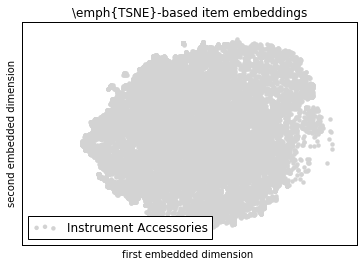

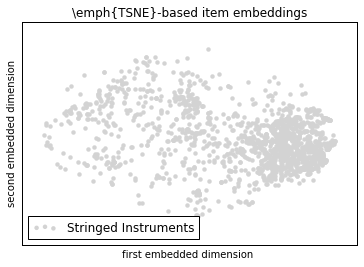

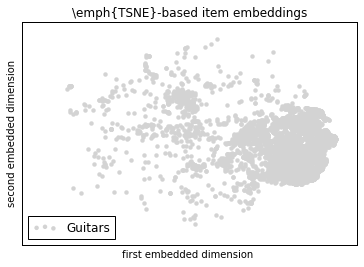

In [33]:
for cat in ['Instrument Accessories', 'Stringed Instruments', 'Guitars']:
    plt.scatter(scatterPlotsX[cat],
            scatterPlotsY[cat], color='lightgrey', lw = 0, label = cat)
    plt.legend(loc='lower left')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("first embedded dimension ")
    plt.ylabel("second embedded dimension")
    plt.title("\emph{TSNE}-based item embeddings")
    plt.show()